In [1]:
import pandas as pd
import sys, numpy as np
import requests, gzip, os, hashlib
from keras.datasets import mnist
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools    
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.size

47040000

In [4]:
x_test.size

7840000

In [5]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
sns.set(style='white', context='notebook', palette='deep')

In [8]:
def countplot(values):
  sns.countplot(values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


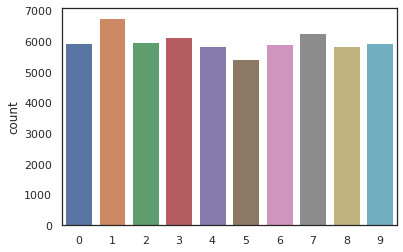

In [9]:
countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


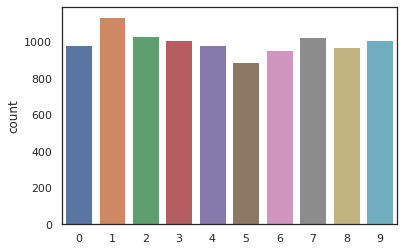

In [10]:
countplot(y_test)

# Normalize

In [11]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [12]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype('float32')

# One Hot Encoding

In [13]:
def convert_to_one_hot_encoding(labels, columns):
  one_hot_labels = np.zeros((len(labels),columns))
  for i, j in enumerate(labels):
    one_hot_labels[i][j] = 1
  return one_hot_labels
   

In [14]:
train_labels = convert_to_one_hot_encoding(y_train, 10)

In [15]:
test_labels = convert_to_one_hot_encoding(y_test, 10)

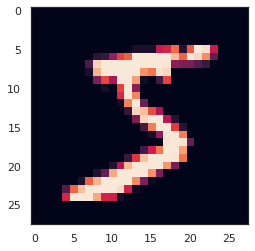

In [16]:
g = plt.imshow(x_train[0][:,:,0])

# CNN

In [17]:
model = Sequential()

In [18]:
model.add(Flatten(input_shape = (28,28,1)))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5

In [20]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)


In [21]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 100

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [25]:
history = model.fit(datagen.flow(x_train, train_labels, batch_size=batch_size),
                              epochs = epochs, verbose = 1, validation_data = (x_test, test_labels), shuffle=True, steps_per_epoch=x_train.shape[0] // batch_size)
                              # , callbacks=[learning_rate_reduction])

Epoch 1/30
600/600 [==============================] - 42s 69ms/step - loss: 0.8748 - accuracy: 0.7086 - val_loss: 0.1019 - val_accuracy: 0.9672
Epoch 2/30
600/600 [==============================] - 41s 68ms/step - loss: 0.2136 - accuracy: 0.9332 - val_loss: 0.0851 - val_accuracy: 0.9724
Epoch 3/30
600/600 [==============================] - 41s 68ms/step - loss: 0.1646 - accuracy: 0.9500 - val_loss: 0.0778 - val_accuracy: 0.9749
Epoch 4/30
600/600 [==============================] - 41s 68ms/step - loss: 0.1524 - accuracy: 0.9527 - val_loss: 0.0717 - val_accuracy: 0.9768
Epoch 5/30
600/600 [==============================] - 41s 68ms/step - loss: 0.1436 - accuracy: 0.9568 - val_loss: 0.0665 - val_accuracy: 0.9798
Epoch 6/30
600/600 [==============================] - 41s 68ms/step - loss: 0.1353 - accuracy: 0.9584 - val_loss: 0.0650 - val_accuracy: 0.9802
Epoch 7/30
600/600 [==============================] - 41s 68ms/step - loss: 0.1323 - accuracy: 0.9616 - val_loss: 0.0612 - val_accuracy:

In [30]:
print("Maximum Validation Accuracy achieved is 98.44%")

Maximum Validation Accuracy achieved is 98.44%


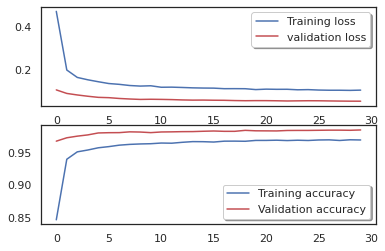

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

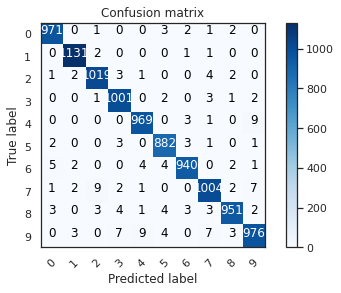

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

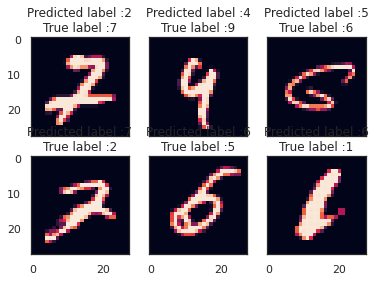

In [28]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)